In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.io as sio
import anndata as ad
import seaborn as sns
import os as os
import sys as sys
sys.path.append('/home/qiuaodon/Desktop/PanCancer_scRNA_analysis/utils/')
from scRNA_utils import *
import operator as op
import matplotlib.colors as mcolors

# load in sc data

In [2]:
data_dir_NHDP = "/home/qiuaodon/Desktop/project_data_new/"
adata_T = sc.read(data_dir_NHDP + '1863-counts_cells_cohort1_T_cells.h5ad')
adata_1 = adata_T[adata_T[:,'PDCD1'].X > 0, :]
adata_B = sc.read(data_dir_NHDP + '1863-counts_cells_cohort1_B_cells.h5ad')
adata_2 = adata_B

In [3]:
adata_1_pseudo = scRNA2PseudoBulkAnnData(adata_1, sample_id_col='sample_id')
adata_2_pseudo = scRNA2PseudoBulkAnnData(adata_2, sample_id_col='sample_id')

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# prepare data matrix for IVtest

In [4]:
DEG_1 = paird_ttest(adata_1, condition_key = 'timepoint', sample_id_col = 'sample_id', patient_id_col = 'patient_id')
DEG_2 = paird_ttest(adata_2, condition_key = 'timepoint', sample_id_col = 'sample_id', patient_id_col = 'patient_id')

Input adata is not pseudo-bulk RNA data. Convert to pseudo-bulk RNA data.


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Input adata is not pseudo-bulk RNA data. Convert to pseudo-bulk RNA data.


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# because some samples are missing, we need to add them to the dataset
# to make sure nosamplefiltered
from scRNA_utils import add_missing_samples
import anndata
# Extract sample_ids
sample_ids_1 = set(adata_1_pseudo.obs['sample_id'])
sample_ids_2 = set(adata_2_pseudo.obs['sample_id'])

# Identify missing sample_ids
missing_sample_ids_1 = sample_ids_2 - sample_ids_1
missing_sample_ids_2 = sample_ids_1 - sample_ids_2

# Add missing sample_ids to each dataset
adata_1_pseudo = add_missing_samples(adata_1_pseudo, missing_sample_ids_1)
adata_2_pseudo = add_missing_samples(adata_2_pseudo, missing_sample_ids_2)
# Sort the obs DataFrame by sample_id in both AnnData objects
adata_1_pseudo = adata_1_pseudo[adata_1_pseudo.obs.sort_values('sample_id').index]
adata_2_pseudo = adata_2_pseudo[adata_2_pseudo.obs.sort_values('sample_id').index]

# Verify that both datasets have the same sample_ids and in the same order
assert (adata_1_pseudo.obs['sample_id'].values == adata_2_pseudo.obs['sample_id'].values).all()

# Now adata_T_pseudo and adata_Endo_pseudo have the same sample_ids in the same order

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [6]:
DEG_1 = DEG_1[DEG_1['pval'] < 0.05]
DEG_2 = DEG_2[DEG_2['pval'] < 0.05]
gene_1 = DEG_1.index.tolist()
gene_2 = DEG_2.index.tolist()

# Filter out invalid gene names
gene_1 = [gene for gene in gene_1 if gene in adata_1_pseudo.var_names]
gene_2 = [gene for gene in gene_2 if gene in adata_2_pseudo.var_names]

gene_1_matrix = adata_1_pseudo[:, gene_1].X
gene_2_matrix = adata_2_pseudo[:, gene_2].X
gene_1_df = pd.DataFrame(gene_1_matrix, columns=gene_1, index=adata_1_pseudo.obs['sample_id'])
gene_2_df = pd.DataFrame(gene_2_matrix, columns=gene_2, index=adata_2_pseudo.obs['sample_id'])
gene_1_df.columns = [i + '_T' for i in gene_1_df.columns]
gene_2_df.columns = [i + '_B' for i in gene_2_df.columns]
gene_df = gene_1_df
gene_df = pd.merge(gene_df, gene_2_df, on='sample_id')

In [7]:
gene_df['treatment'] = gene_df.index.str.contains('On').astype(int)
# get patient id from sample id remove the _On or _Pre
gene_df['patient_id'] = gene_df.index.str.replace('_On', '').str.replace('_Pre', '')
gene_df['treatment'].value_counts()

1    31
0    31
Name: treatment, dtype: int64

## group the DEGpairs together using L and R

In [8]:
results = pd.read_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_PD1vsB_fisherz_corr03.xlsx')
results = results.drop(columns=['Unnamed: 0'])

# # Remove the suffix '_X' from g1 and g2
results['g1'] = results['g1'].str.replace(r'_\w+', '', regex=True)
results['g2'] = results['g2'].str.replace(r'_\w+', '', regex=True)

In [9]:
# only keep the significant results with correlation > 0.3 or < -0.3
results = results[(results['g1vsg2_correlation'] > 0.3)]

In [10]:
calculate_g1_L_correlation(results, adata_1_pseudo)
calculate_g2_R_correlation(results, adata_2_pseudo)

,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,g1vsL_correlation,g2vsR_correlation
0,SPON2,SESN1,HMGB2,DSG2,0.083489,0.505992,0.236783,0.473496,0.756635
1,IL18R1,TLE1,PLAT,LRP1,0.095187,0.479841,0.175523,0.519314,0.397614
2,IL18R1,SLC15A4,TNFSF10,TNFRSF10D,0.070423,0.449315,0.191054,0.022185,0.501571
3,IL18R1,SLC15A4,PLAT,LRP1,0.255149,0.449315,0.100211,0.519314,0.403977
4,RGS1,SLC15A4,CALR,HMMR,0.054661,0.430948,0.273040,-0.001635,0.481473
...,...,...,...,...,...,...,...,...,...
240,PMAIP1,SOCS1,ANXA1,CXCR3,0.057026,0.300412,0.272561,-0.118788,-0.064026
241,PMAIP1,SOCS1,THBS1,ITGAM,0.064585,0.300412,0.262815,-0.176498,-0.088659
242,PMAIP1,SOCS1,ITGB1,IGF1R,0.051967,0.300412,0.274454,0.032771,-0.096401
243,PMAIP1,SOCS1,ITGB1,ITGAX,0.051004,0.300412,0.275653,0.032771,-0.167322


In [11]:
# remove the rows with g1vsL_correlation < 0.3 
results = results[(abs(results['g1vsL_correlation']) > 0.3) & (results['g1vsL_correlation'] < 0.99)]
# remove the rows with g2vsR_correlation < 0.3 
results = results[(abs(results['g2vsR_correlation']) > 0.3) & (results['g2vsR_correlation'] < 0.99)]

In [12]:
results

,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,g1vsL_correlation,g2vsR_correlation
0,SPON2,SESN1,HMGB2,DSG2,0.083489,0.505992,0.236783,0.473496,0.756635
1,IL18R1,TLE1,PLAT,LRP1,0.095187,0.479841,0.175523,0.519314,0.397614
3,IL18R1,SLC15A4,PLAT,LRP1,0.255149,0.449315,0.100211,0.519314,0.403977
6,SPON2,SOCS1,HMGB2,DSG2,0.181746,0.423296,0.192218,0.473496,0.586480
7,NEAT1,CEMIP2,HMGB2,DSG2,0.054463,0.387049,0.272405,0.416178,0.724268
11,SLA,AC025164.1,CXCL13,P2RY14,0.091951,0.383240,0.218402,0.398089,0.541034
17,CXCR4,CEMIP2,ANXA1,CCR7,0.146360,0.356985,0.182511,0.506629,0.778998
19,NEAT1,SESN1,HMGB2,DSG2,0.121335,0.353845,0.219346,0.416178,0.756635
23,BCL2L11,TLE1,HMGB2,CDH1,0.083705,0.341859,0.236110,0.538116,0.500456
31,CEMIP2,KLF2,ITGA4,JAM3,0.050879,0.336902,0.271115,0.323923,0.305711


In [14]:
import pandas as pd
grouped_results = results.groupby(["L", "R"])

# Display grouped data
grouped_dict = { (ligand, receptor): group for (ligand, receptor), group in grouped_results }

# Create a new DataFrame to hold the GEM1 and GEM2 groupings
grouped_data = []
tracked_gem1 = set()
tracked_gem2 = set()

min_gene_num = 1

# Temporary list to hold data before creating DataFrame
temp_data = []

for (ligand, receptor), group in grouped_results:
    gem1 = group["g1"].drop_duplicates().tolist()
    gem2 = group["g2"].drop_duplicates().tolist()
    
    # Check the overlap between current GEM_g1 and previously tracked GEM_g1
    overlap_gem1 = len(set(gem1) & tracked_gem1)
    overlap_gem2 = len(set(gem2) & tracked_gem2)
    
    # Filter to include only those with at least three genes in GEM_g1 and GEM_g2
    # and where the overlap is below the maximum allowable threshold
    if len(gem1) > min_gene_num :
        temp_data.append({
            "Ligand": ligand,
            "Receptor": receptor,
            "GEM_g1": gem1,
            "GEM_g2": gem2,
            "Num_genes_g1": len(gem1),
            "Num_genes_g2": len(gem2)
        })
        # Update the tracked GEM_g1 and GEM_g2 sets
        tracked_gem1.update(gem1)
        tracked_gem2.update(gem2)

# Convert the temporary data to a DataFrame
grouped_df = pd.DataFrame(temp_data)

# Function to find overlapping rows
def find_overlapping_rows(df, column_name):
    overlap_info = []
    for index, row in df.iterrows():
        current_set = set(row[column_name])
        overlapping_rows = []
        for other_index, other_row in df.iterrows():
            if index != other_index:
                other_set = set(other_row[column_name])
                overlap = len(current_set & other_set)
                if overlap > len(current_set) / 3: # Set the threshold for overlap
                    overlapping_rows.append(other_index)
        overlap_info.append(overlapping_rows)
    return overlap_info

# Add columns for overlapping rows in GEM_g1 and GEM_g2
grouped_df["Overlapping_g1"] = find_overlapping_rows(grouped_df, "GEM_g1")
grouped_df["Overlapping_g2"] = find_overlapping_rows(grouped_df, "GEM_g2")

grouped_df


,Ligand,Receptor,GEM_g1,GEM_g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2
0,CXCL13,CXCR3,"[IL7R, CXCR4, TAGAP]",[SESN1],3,1,[1],"[1, 3]"
1,FASLG,FAS,"[IL7R, NFKBIA, CXCR4]",[SESN1],3,1,[0],"[0, 3]"
2,HMGB2,CDH1,"[BCL2L11, SPON2, PRDM1]","[TLE1, SLC15A4]",3,2,[3],[]
3,HMGB2,DSG2,"[SPON2, NEAT1, BCL2L11]","[SESN1, SOCS1, CEMIP2]",3,3,[2],[]
4,ITGA4,JAM3,"[CEMIP2, CRYBG1]","[KLF2, AC025164.1]",2,2,[],[]


In [15]:
# rank each GEM_g1 by order of name inside
grouped_df['GEM_g1'] = grouped_df['GEM_g1'].apply(lambda x: sorted(x))
grouped_df['GEM_g2'] = grouped_df['GEM_g2'].apply(lambda x: sorted(x))

In [16]:
import pandas as pd
grouped_results = results.groupby(["L", "R"])

# Display grouped data
grouped_dict = { (ligand, receptor): group for (ligand, receptor), group in grouped_results }

# Create a new DataFrame to hold the GEM1 and GEM2 groupings
grouped_data = []
tracked_gem1 = set()
tracked_gem2 = set()

min_gene_num = 1

# Temporary list to hold data before creating DataFrame
temp_data = []

for (ligand, receptor), group in grouped_results:
    gem1 = group["g1"].drop_duplicates().tolist()
    gem2 = group["g2"].drop_duplicates().tolist()
    
    # Check the overlap between current GEM_g1 and previously tracked GEM_g1
    overlap_gem1 = len(set(gem1) & tracked_gem1)
    overlap_gem2 = len(set(gem2) & tracked_gem2)
    
    # Filter to include only those with at least three genes in GEM_g1 and GEM_g2
    # and where the overlap is below the maximum allowable threshold
    if len(gem1) > min_gene_num and len(gem2) > min_gene_num:
        temp_data.append({
            "L": ligand,
            "R": receptor,
            "g1": gem1,
            "g2": gem2,
            "Num_genes_g1": len(gem1),
            "Num_genes_g2": len(gem2)
        })
        # Update the tracked GEM_g1 and GEM_g2 sets
        tracked_gem1.update(gem1)
        tracked_gem2.update(gem2)

# Convert the temporary data to a DataFrame
grouped_df = pd.DataFrame(temp_data)

# Function to find overlapping rows
def find_overlapping_rows(df, column_name):
    overlap_info = []
    for index, row in df.iterrows():
        current_set = set(row[column_name])
        overlapping_rows = []
        for other_index, other_row in df.iterrows():
            if index != other_index:
                other_set = set(other_row[column_name])
                overlap = len(current_set & other_set)
                if overlap > len(current_set) / 3: # Set the threshold for overlap
                    overlapping_rows.append(other_index)
        overlap_info.append(overlapping_rows)
    return overlap_info

# Add columns for overlapping rows in GEM_g1 and GEM_g2
grouped_df["Overlapping_g1"] = find_overlapping_rows(grouped_df, "g1")
grouped_df["Overlapping_g2"] = find_overlapping_rows(grouped_df, "g2")


In [17]:
# rank each GEM_g1 by order of name inside
grouped_df['g1'] = grouped_df['g1'].apply(lambda x: sorted(x))
grouped_df['g2'] = grouped_df['g2'].apply(lambda x: sorted(x))
grouped_df

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2
0,HMGB2,CDH1,"[BCL2L11, PRDM1, SPON2]","[SLC15A4, TLE1]",3,2,[1],[]
1,HMGB2,DSG2,"[BCL2L11, NEAT1, SPON2]","[CEMIP2, SESN1, SOCS1]",3,3,[0],[]
2,ITGA4,JAM3,"[CEMIP2, CRYBG1]","[AC025164.1, KLF2]",2,2,[],[]


In [18]:
# remove the -0 or -1 in the adata_2_pseudo index
adata_2_pseudo.obs.index = adata_2_pseudo.obs.index.str.replace('-0', '').str.replace('-1', '')
# remove the -0 or -1 in the adata_1_pseudo index

In [19]:
#calculate the correlation between g1 and g2
calculate_GEM_correlation(grouped_df, adata_1_pseudo, adata_2_pseudo)
#calculate the residuals correlation between g1, g2 and LR
calculate_residuals_GEM_correlation(grouped_df, adata_1_pseudo, adata_2_pseudo)

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation
0,HMGB2,CDH1,"[BCL2L11, PRDM1, SPON2]","[SLC15A4, TLE1]",3,2,[1],[],0.392341,0.319529
1,HMGB2,DSG2,"[BCL2L11, NEAT1, SPON2]","[CEMIP2, SESN1, SOCS1]",3,3,[0],[],0.662704,0.550000
2,ITGA4,JAM3,"[CEMIP2, CRYBG1]","[AC025164.1, KLF2]",2,2,[],[],0.409930,0.306039


In [20]:
# cmap color from grey to blue for umap
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ["grey", "blue"])


In [21]:
# Define a function to append '_T' to each gene name
def append_suffix(gene_list, suffix='_T'):
    # Ensure it's a list and not NaN or another unexpected type
    if isinstance(gene_list, list):
        return [gene + suffix for gene in gene_list]
    else:
        print("Unexpected format:", gene_list)
        return gene_list

# Apply the function to the GEM_g1 column to add '_T' to each gene name
DEG_pairs_T = grouped_df.copy()
DEG_pairs_T['g1'] = grouped_df['g1'].apply(lambda x: append_suffix(x, '_T'))

# Similarly for GEM_g2 if needed
DEG_pairs_T['g2'] = grouped_df['g2'].apply(lambda x: append_suffix(x, '_B'))
# remove the genes not in gene_df from each row in DEG_pairs_T but keep the row
DEG_pairs_T['g1'] = DEG_pairs_T['g1'].apply(lambda x: [gene for gene in x if gene in gene_df.columns])
DEG_pairs_T['g2'] = DEG_pairs_T['g2'].apply(lambda x: [gene for gene in x if gene in gene_df.columns])


# add GEM_1_T, GEM_2_T and so on to gene_df
for i, row in DEG_pairs_T.iterrows():
    GEM_1 = DEG_pairs_T.loc[i, 'g1']
    GEM_2 = DEG_pairs_T.loc[i, 'g2']
    gene_df['GEM_' + str(i) + '_T'] = gene_df[GEM_1].mean(axis=1)
    gene_df['GEM_' + str(i) + '_B'] = gene_df[GEM_2].mean(axis=1)
gene_df

,AC004687.1_T,AC004817.3_T,AC004951.1_T,AC006369.1_T,AC007038.2_T,AC015813.1_T,AC016831.5_T,AC021188.1_T,AC023157.3_T,AC025164.1_T,...,GALNTL6_B,LINC01685_B,treatment,patient_id,GEM_0_T,GEM_0_B,GEM_1_T,GEM_1_B,GEM_2_T,GEM_2_B
sample_id,,,,,,,,,,,,,,,,,,,,,
BIOKEY_10_On,309.215912,189.972443,46.985409,88.311661,13.239152,40.373478,43.434666,111.079369,77.687202,379.605682,...,10.585213,119.495178,1,BIOKEY_10,1016.223389,434.582901,1111.602661,1386.978577,1097.934082,1476.752380
BIOKEY_10_Pre,563.980347,44.845234,55.078514,81.338425,5.761608,25.467459,9.838195,82.176804,36.126411,164.164597,...,0.000000,0.000000,0,BIOKEY_10,382.707001,45.267735,675.684753,513.244314,460.806549,604.385132
BIOKEY_11_On,268.598755,148.075867,37.323822,188.380936,10.964890,28.348480,45.273457,68.983269,41.890564,551.513916,...,0.000000,0.000000,1,BIOKEY_11,956.489197,385.519638,1098.704834,1680.969869,836.578064,3691.113281
BIOKEY_11_Pre,391.792786,26.553766,51.684788,149.571411,0.000000,17.950109,23.245640,79.012733,89.163200,415.800201,...,0.000000,0.000000,0,BIOKEY_11,370.379425,208.883965,683.956238,879.973969,392.829285,1587.781219
BIOKEY_12_On,329.073425,308.417725,18.504068,184.849304,5.138805,24.086304,120.066422,34.435535,70.810493,540.817444,...,279.785614,273.152374,1,BIOKEY_12,1087.145386,536.904388,1188.213989,1907.421021,1817.624512,2064.808533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BIOKEY_7_Pre,420.561005,0.000000,0.000000,1083.950928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,BIOKEY_7,236.239136,436.871002,221.130005,291.247335,843.929871,2811.783264
BIOKEY_8_On,269.902893,409.661530,45.042774,241.828293,0.000000,0.000000,82.949020,111.544533,60.184547,431.229431,...,0.000000,0.000000,1,BIOKEY_8,833.697998,663.571350,847.015869,2296.711222,1073.292969,2564.340698
BIOKEY_8_Pre,850.882141,0.000000,0.000000,193.594498,0.000000,0.000000,236.877213,0.000000,0.000000,245.685928,...,0.000000,0.000000,0,BIOKEY_8,520.278564,1318.377563,992.020691,850.964274,806.508057,1276.157593


In [22]:
# add GEM_1_T, GEM_2_T and so on to adata
DEG_pairs = grouped_df
for i, row in DEG_pairs.iterrows():
    GEM_1 = DEG_pairs.loc[i, 'g1']
    GEM_2 = DEG_pairs.loc[i, 'g2']
    # add GEMs to adata_1_pseudo and adata_2_pseudo
    adata_1_pseudo.obs['GEM_' + str(i) + '_T'] = adata_1_pseudo[:, GEM_1].X.mean(axis=1)
    adata_2_pseudo.obs['GEM_' + str(i) + '_B'] = adata_2_pseudo[:, GEM_2].X.mean(axis=1)
    # add GEMs to adata_1 and adata_2
    adata_1.obs['GEM_' + str(i) + '_T'] = adata_1[:, GEM_1].X.mean(axis=1)
    adata_2.obs['GEM_' + str(i) + '_B'] = adata_2[:, GEM_2].X.mean(axis=1)

/tmp/ipykernel_1575769/2646218255.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1_pseudo.obs['GEM_' + str(i) + '_T'] = adata_1_pseudo[:, GEM_1].X.mean(axis=1)
/tmp/ipykernel_1575769/2646218255.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_2_pseudo.obs['GEM_' + str(i) + '_B'] = adata_2_pseudo[:, GEM_2].X.mean(axis=1)
/tmp/ipykernel_1575769/2646218255.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['GEM_' + str(i) + '_T'] = adata_1[:, GEM_1].X.mean(axis=1)


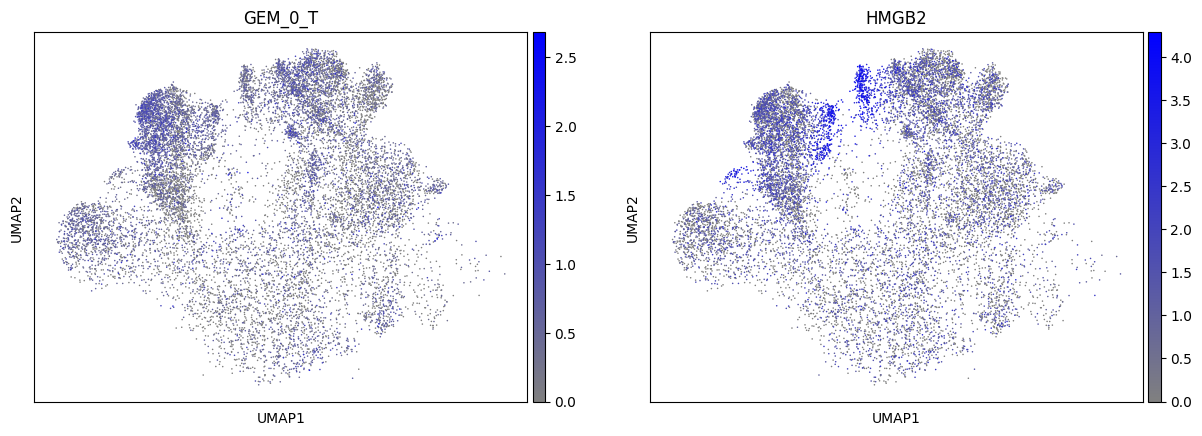

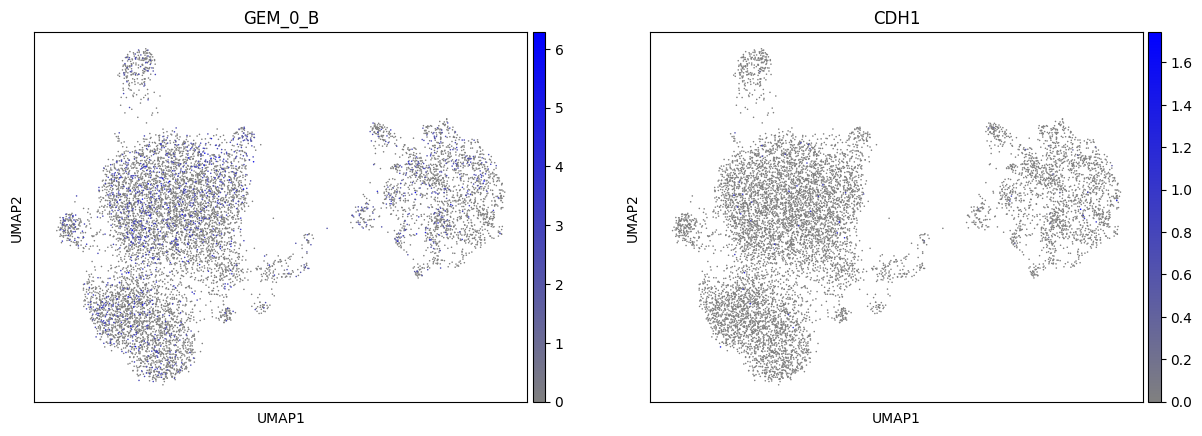

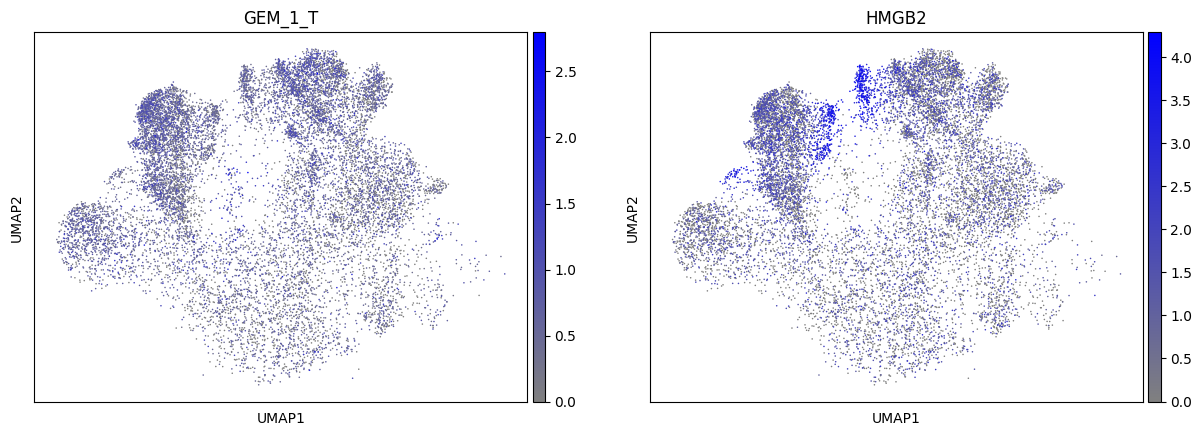

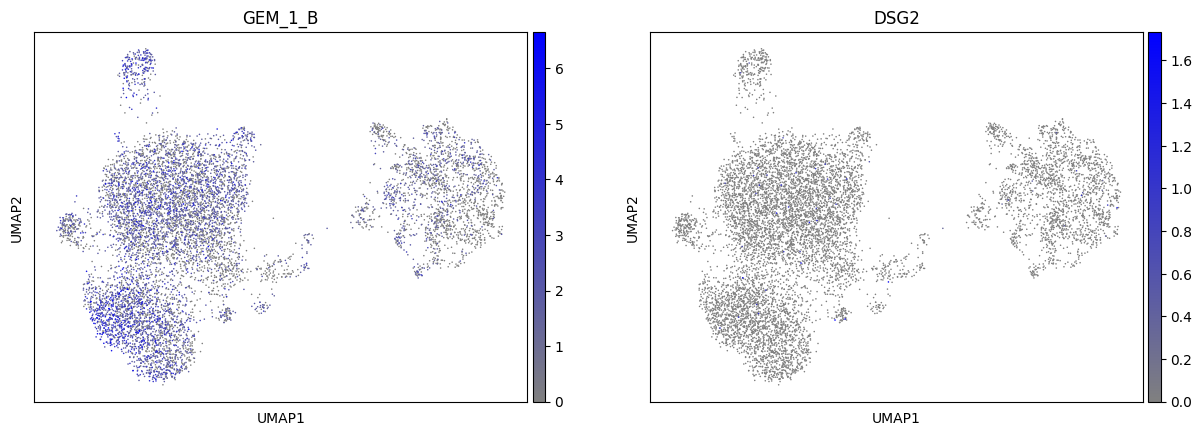

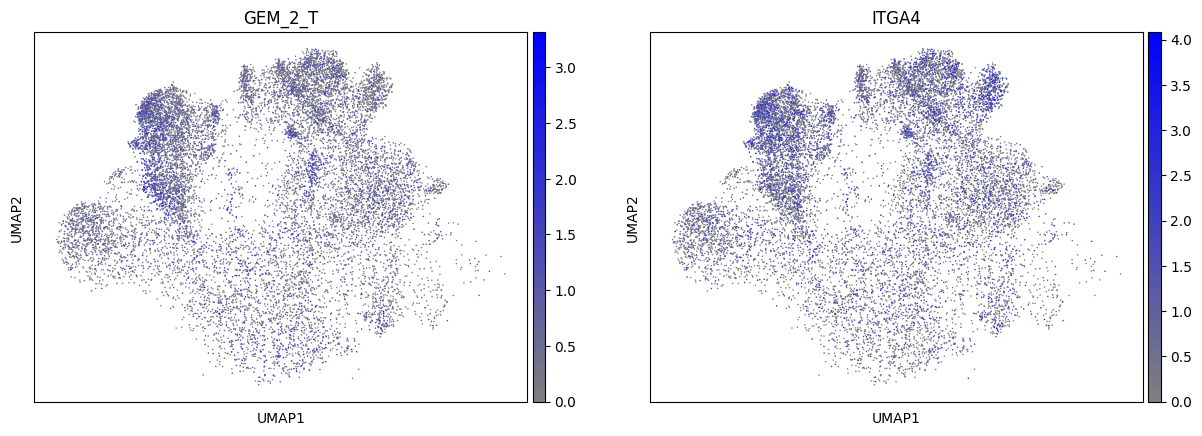

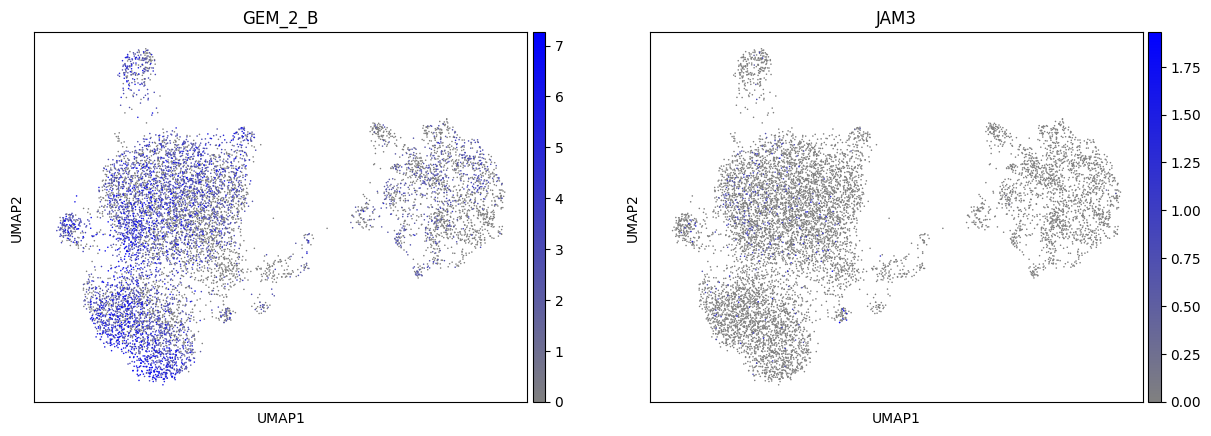

In [23]:
# plot the UMAP of GEMs
for i, row in DEG_pairs_T.iterrows():
    GEM_1 = DEG_pairs.loc[i, 'g1']
    GEM_2 = DEG_pairs.loc[i, 'g2']
    L = DEG_pairs.loc[i, 'L']
    R = DEG_pairs.loc[i, 'R']
    sc.pl.umap(adata_1, color=['GEM_' + str(i) + '_T', L], title='GEM_' + str(i) + '_T', cmap=cmap, size = 5)
    sc.pl.umap(adata_2, color=['GEM_' + str(i) + '_B', R], title='GEM_' + str(i) + '_B', cmap=cmap, size = 5)

In [25]:
grouped_df = DEG_pairs

In [35]:
grouped_df['GEM_1'] = 'GEM_' + grouped_df.index.astype(str) + '_T'
grouped_df['GEM_2'] = 'GEM_' + grouped_df.index.astype(str) + '_B'

In [39]:
CIT_GEM_test(grouped_df, adata_1_pseudo, adata_2_pseudo, gene_df, method="fisherz")

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,GEM_1,GEM_2,pValue
0,HMGB2,CDH1,"[BCL2L11, PRDM1, SPON2]","[SLC15A4, TLE1]",3,2,[1],[],0.392341,0.319529,GEM_0_T,GEM_0_B,0.011677
1,HMGB2,DSG2,"[BCL2L11, NEAT1, SPON2]","[CEMIP2, SESN1, SOCS1]",3,3,[0],[],0.662704,0.550000,GEM_1_T,GEM_1_B,0.000002
2,ITGA4,JAM3,"[CEMIP2, CRYBG1]","[AC025164.1, KLF2]",2,2,[],[],0.409930,0.306039,GEM_2_T,GEM_2_B,0.016046


In [38]:
# save the grouped_df to excel
DEG_pairs.to_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_PD1vsB_grouped_0920.xlsx')